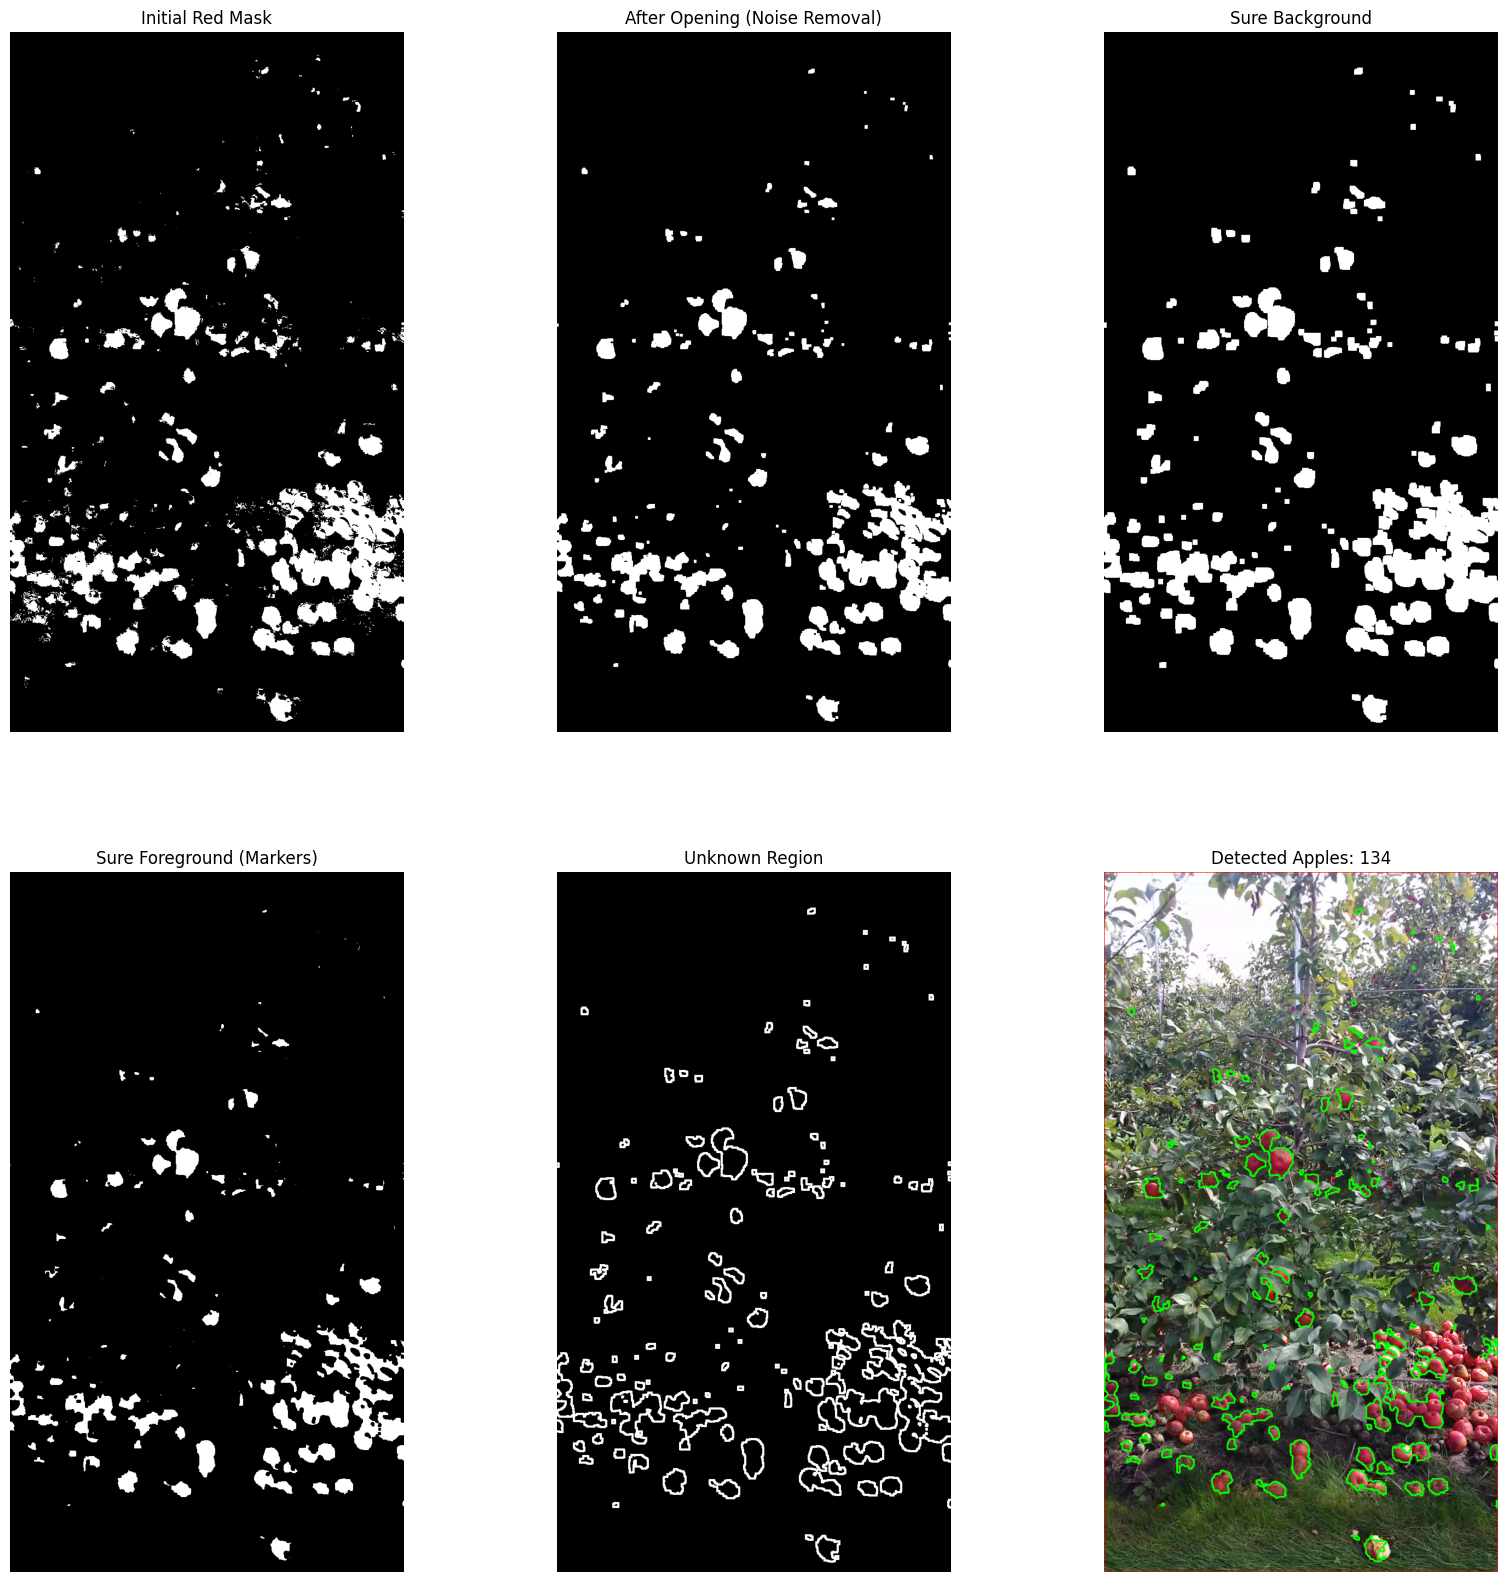


Final apple count: 134


In [45]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Image file path
image_path = "C:/Users/varou/OneDrive - UWE Bristol/Resit ItMV/Project Files/detection/detection/test/images/dataset1_back_1.png"

# Load image
image = cv2.imread(image_path)

if image is None:
    print(f"Error: Could not load image from {image_path}")
else:
    # Convert image to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Updated red HSV range (these ranges might need fine-tuning for your specific images)
    lower_red1 = np.array([0, 70, 50])
    upper_red1 = np.array([20, 255, 255])
    lower_red2 = np.array([160, 70, 50])
    upper_red2 = np.array([180, 255, 255])

    # Create and combine red masks
    mask1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
    red_mask = cv2.add(mask1, mask2)

    # Morphological Operations for Watershed Prep
    # Opening to remove small noise and closing to fill small holes.
    kernel = np.ones((3, 3), np.uint8)

    # Noise removal with opening
    opening = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel, iterations=2)

    # Sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=2)

    # Finding sure foreground area using Distance Transform
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.1 * dist_transform.max(), 255, 0) # Adjust threshold if needed

    # Unknown region (sure_bg - sure_fg)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Mark the unknown region with 0
    markers[unknown == 255] = 0

    # Apply Watershed
    markers = cv2.watershed(image, markers)
    image[markers == -1] = [0, 0, 255]  # Mark watershed boundaries in red

    # Find contours from the watershed segmented image
    apple_count = 0
    contour_image = image.copy() # Use the original image for drawing contours

    # Iterate through unique markers (excluding background and unknown)
    # The markers from watershed will label each segmented object.
    # Watershed boundaries are -1.
    for i in np.unique(markers):
        if i == -1 or i == 1:  # -1 is watershed boundary, 1 is background (after adding 1 to markers)
            continue

        # Create a mask for the current apple
        mask = np.zeros(image.shape[:2], dtype="uint8")
        mask[markers == i] = 255

        # Find contours for this individual apple
        contours, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours: # Check if any contours were found for this marker
            # Take the largest one if multiple exist
            largest_contour = max(contours, key=cv2.contourArea)

            area = cv2.contourArea(largest_contour)

            # Define apple size criteria
            min_apple_area = 10 # Minimum area for a detected apple
            max_apple_area = 200000 # Maximum area for a detected apple

            if min_apple_area < area < max_apple_area:
                perimeter = cv2.arcLength(largest_contour, True)
                if perimeter == 0:
                    continue

                circularity = 4 * np.pi * area / (perimeter**2)
                hull = cv2.convexHull(largest_contour)
                hull_area = cv2.contourArea(hull)
                solidity = area / hull_area if hull_area > 0 else 0

                # Apples are generally roundish, so circularity should be relatively high.
                # Solidity helps in identifying solid objects vs. fragmented ones.
                if circularity > 0.2 and solidity > 0.2: # Adjust these thresholds
                    cv2.drawContours(contour_image, [largest_contour], -1, (0, 255, 0), 2)
                    apple_count += 1

    # Display results
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Original image with watershed boundaries
    contour_image_rgb = cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB) # Image with final apple contours

    plt.figure(figsize=(20, 20))

    plt.subplot(2, 3, 1)
    plt.imshow(red_mask, cmap='gray')
    plt.title("Initial Red Mask")
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(opening, cmap='gray')
    plt.title("After Opening (Noise Removal)")
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(sure_bg, cmap='gray')
    plt.title("Sure Background")
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(sure_fg, cmap='gray')
    plt.title("Sure Foreground (Markers)")
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(unknown, cmap='gray')
    plt.title("Unknown Region")
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(contour_image_rgb)
    plt.title(f"Detected Apples: {apple_count}")
    plt.axis('off')

    plt.show()

    print(f"\nFinal apple count: {apple_count}")